In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
%matplotlib inline

In [2]:
#Get Current Working Directory
os.getcwd()

'C:\\Users\\Pranay\\Projects\\GitHub\\Capstone_II'

In [3]:
#Read CSV data
df=pd.read_csv('data/step3_output.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,0,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,0,1,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,0,0,1,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
#Get data types for all the colums 
df.dtypes

age                 int64
job                object
marital            object
education          object
default             int64
housing             int64
loan                int64
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
#Get all the columns with object datatype excluding dependent column
only_obj=df.select_dtypes(include=['object'])
only_obj.drop(['y'],axis=1,inplace=True)
col=only_obj.columns

C:\Users\Pranay\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#Do One Hot encoding for the objects columns
df=pd.get_dummies(df,columns=col)

In [7]:
#Group Age Columns
df['Binned_Age']=pd.cut(
    df['age'],
    bins=[-np.inf,20,30,40,50,60,70,80,90,np.inf],
    labels=['0-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
)

In [8]:
#Group Emp_Var_Rate columns
df['Binned_Emp_Var_Rate']=pd.cut(
    df['emp.var.rate'],
    bins=[-np.inf,-3.5,-2.5,-1.5,-0.5,0.5,1.5,np.inf],
    labels=[-4,-3,-2,-1,0,1,2]
)

In [9]:
df['euribor3m']=df['euribor3m'].round(1)
df['cons.price.idx']=df['cons.price.idx'].round(2)

In [10]:
df.y.replace({'yes':1,'no':0},inplace=True)

In [11]:
X = df.drop(['Binned_Age','y','emp.var.rate'], axis=1)
y=df.y
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)

In [13]:
classes=[1,0]
y=y_train
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes, y)
weights

C:\Users\Pranay\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1, 0], y=24505    0
40235    1
40010    0
18548    0
26176    0
        ..
7813     0
32511    0
5192     0
12172    0
33003    0
Name: y, Length: 30415, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([4.4272198 , 0.56365827])

In [14]:
class_weights = compute_class_weight('balanced',np.unique(y_train),
                                                 y_train)
class_weights

C:\Users\Pranay\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=24505    0
40235    1
40010    0
18548    0
26176    0
        ..
7813     0
32511    0
5192     0
12172    0
33003    0
Name: y, Length: 30415, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.56365827, 4.4272198 ])

In [15]:
weights

array([4.4272198 , 0.56365827])

In [16]:
clf = LogisticRegression(class_weight={0:0.56365827,1:4.4272198},max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.56365827, 1: 4.4272198}, max_iter=1000)

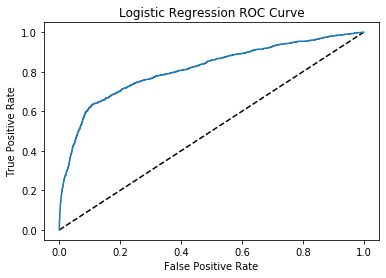

In [17]:
from sklearn.metrics import roc_curve
y_pred_prob=clf.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8126559511101664


In [19]:
THRESHOLD = 0.70
#y_pred=clf.predict(X_test)
y_pred=np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [20]:
print('Accuracy Score by after scaling the data and using logistic regression',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Logistic Regression: f1-score=%.3f' % (f1))

Accuracy Score by after scaling the data and using logistic regression 0.8820396488805602
Logistic Regression: f1-score=0.886


In [21]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[8321  695]
 [ 501  622]]


In [22]:
print('Classification Report after scaling the data and using Logistic regression\n',classification_report(y_test, y_pred))

Classification Report after scaling the data and using Logistic regression
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      9016
           1       0.47      0.55      0.51      1123

    accuracy                           0.88     10139
   macro avg       0.71      0.74      0.72     10139
weighted avg       0.89      0.88      0.89     10139



In [23]:
clf = RandomForestClassifier(n_estimators=200,class_weight={0:0.56365827,1:4.4272198})
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.56365827, 1: 4.4272198},
                       n_estimators=200)

In [24]:
y_pred=clf.predict(X_test)
print('Accuracy Score of Random Forest is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Random Forest: f1-score=%.3f' % (f1))

Accuracy Score of Random Forest is 0.8946641680639116
Random Forest: f1-score=0.880


In [25]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[8743  273]
 [ 795  328]]


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9016
           1       0.55      0.29      0.38      1123

    accuracy                           0.89     10139
   macro avg       0.73      0.63      0.66     10139
weighted avg       0.88      0.89      0.88     10139



In [27]:
importances = list(clf.feature_importances_)

In [28]:
feature_list = list(df.drop(['Binned_Age','y'], axis=1).columns)
feature_list

['age',
 'default',
 'housing',
 'loan',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'poutcome_failure',
 'poutcome_nonexistent',
 'poutcome_success',
 'Binned_Emp_Var_Rate']

In [29]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

In [30]:
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [31]:
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: age                  Importance: 0.17
Variable: campaign             Importance: 0.09
Variable: cons.conf.idx        Importance: 0.08
Variable: euribor3m            Importance: 0.06
Variable: housing              Importance: 0.04
Variable: poutcome_success     Importance: 0.04
Variable: cons.price.idx       Importance: 0.03
Variable: loan                 Importance: 0.02
Variable: pdays                Importance: 0.02
Variable: previous             Importance: 0.02
Variable: emp.var.rate         Importance: 0.02
Variable: nr.employed          Importance: 0.02
Variable: marital_divorced     Importance: 0.02
Variable: marital_married      Importance: 0.02
Variable: education_basic.9y   Importance: 0.02
Variable: education_professional.course Importance: 0.02
Variable: month_sep            Importance: 0.02
Variable: day_of_week_fri      Importance: 0.02
Variable: day_of_week_mon      Importance: 0.02
Variable: day_of_week_thu      Importance: 0.02
Variable: day_of_week_tue      

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

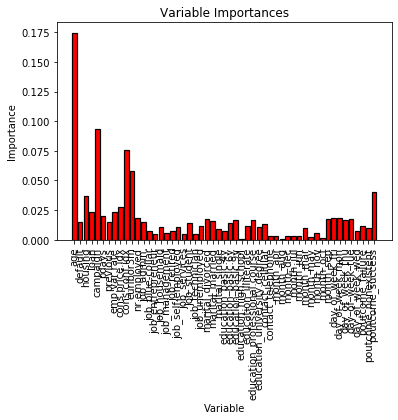

In [32]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

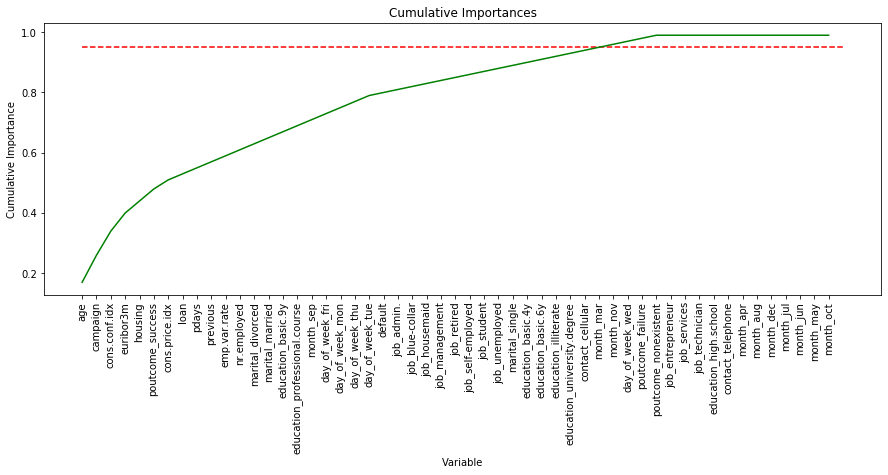

In [33]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [34]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0]+1)

Number of features for 95% importance: 37


In [35]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:36]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_features = X_train[:, important_indices]
important_test_features = X_test[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (30415, 36)
Important test features shape: (10139, 36)


In [36]:
important_feature_names

['age',
 'campaign',
 'cons.conf.idx',
 'euribor3m',
 'housing',
 'poutcome_success',
 'cons.price.idx',
 'loan',
 'pdays',
 'previous',
 'emp.var.rate',
 'nr.employed',
 'marital_divorced',
 'marital_married',
 'education_basic.9y',
 'education_professional.course',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'default',
 'job_admin.',
 'job_blue-collar',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_student',
 'job_unemployed',
 'marital_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_illiterate',
 'education_university.degree',
 'contact_cellular']

In [37]:
clf.fit(important_train_features, y_train)
y_pred=clf.predict(important_test_features)

In [38]:
print('Accuracy Score of Random Forest is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Random Forest: f1-score=%.3f' % (f1))

Accuracy Score of Random Forest is 0.8924943288292732
Random Forest: f1-score=0.879


In [39]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[8711  305]
 [ 785  338]]


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9016
           1       0.53      0.30      0.38      1123

    accuracy                           0.89     10139
   macro avg       0.72      0.63      0.66     10139
weighted avg       0.87      0.89      0.88     10139



In [41]:
from sklearn.linear_model import RidgeClassifier
ridge=RidgeClassifier(class_weight={0:0.56365827,1:4.4272198})
ridge.fit(X_train, y_train)

RidgeClassifier(class_weight={0: 0.56365827, 1: 4.4272198})

In [42]:
y_pred=ridge.predict(X_test)
print('Accuracy Score of Ridge Regression is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Ridge Regression: f1-score=%.3f' % (f1))

Accuracy Score of Ridge Regression is 0.8269060065095177
Ridge Regression: f1-score=0.848


In [43]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7643 1373]
 [ 382  741]]


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      9016
           1       0.35      0.66      0.46      1123

    accuracy                           0.83     10139
   macro avg       0.65      0.75      0.68     10139
weighted avg       0.89      0.83      0.85     10139



In [45]:
from sklearn.linear_model import SGDClassifier as svm
clf_svm = svm(class_weight={0:0.56365827,1:4.4272198})
clf_svm.fit(X_train, y_train)

SGDClassifier(class_weight={0: 0.56365827, 1: 4.4272198})

In [46]:
y_pred=clf_svm.predict(X_test)
print('Accuracy Score of Ridge Regression is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Ridge Regression: f1-score=%.3f' % (f1))

Accuracy Score of Ridge Regression is 0.820495117861722
Ridge Regression: f1-score=0.844


In [47]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7579 1437]
 [ 383  740]]


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      9016
           1       0.34      0.66      0.45      1123

    accuracy                           0.82     10139
   macro avg       0.65      0.75      0.67     10139
weighted avg       0.88      0.82      0.84     10139



In [49]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GBC = GradientBoostingClassifier(n_estimators=1000)
clf_GBC.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=1000)

In [50]:
y_pred=clf_GBC.predict(X_test)
print('Accuracy Score of Ridge Regression is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Ridge Regression: f1-score=%.3f' % (f1))

Accuracy Score of Ridge Regression is 0.9026531216096262
Ridge Regression: f1-score=0.884


In [51]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[8851  165]
 [ 822  301]]


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9016
           1       0.65      0.27      0.38      1123

    accuracy                           0.90     10139
   macro avg       0.78      0.62      0.66     10139
weighted avg       0.89      0.90      0.88     10139



In [53]:
y.value_counts()

0    26980
1     3435
Name: y, dtype: int64

In [54]:
y_train.value_counts()

0    26980
1     3435
Name: y, dtype: int64

In [55]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

In [56]:
y_res.value_counts()

1    26980
0    26980
Name: y, dtype: int64

In [111]:
clf = LogisticRegression()
clf.fit(X_res, y_res)

LogisticRegression()

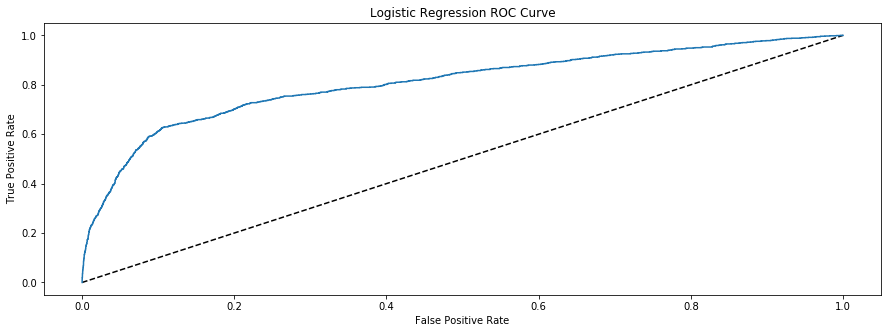

In [112]:
y_pred_prob=clf.predict_proba(X_test)[:,1]
fpr,tpr,thresholds=roc_curve(y_test,y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr,label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [113]:
from sklearn.metrics import roc_auc_score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8079530226663432


In [118]:
THRESHOLD = 0.65
#y_pred=clf.predict(X_test)
y_pred=np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [119]:
print('Accuracy Score by after scaling the data and using logistic regression',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Logistic Regression: f1-score=%.3f' % (f1))

Accuracy Score by after scaling the data and using logistic regression 0.8711904527073676
Logistic Regression: f1-score=0.880


In [120]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[8160  856]
 [ 450  673]]


In [121]:
print('Classification Report after scaling the data and using Logistic regression\n',classification_report(y_test, y_pred))

Classification Report after scaling the data and using Logistic regression
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      9016
           1       0.44      0.60      0.51      1123

    accuracy                           0.87     10139
   macro avg       0.69      0.75      0.72     10139
weighted avg       0.89      0.87      0.88     10139



In [95]:
ridge=RidgeClassifier()
ridge.fit(X_res, y_res)

RidgeClassifier()

In [96]:
y_pred=ridge.predict(X_test)
print('Accuracy Score of Ridge Regression is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Ridge Regression: f1-score=%.3f' % (f1))

Accuracy Score of Ridge Regression is 0.8121116480915278
Ridge Regression: f1-score=0.838


In [97]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7481 1535]
 [ 370  753]]


In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      9016
           1       0.33      0.67      0.44      1123

    accuracy                           0.81     10139
   macro avg       0.64      0.75      0.66     10139
weighted avg       0.88      0.81      0.84     10139



In [99]:
clf_svm = svm()
clf_svm.fit(X_res, y_res)

SGDClassifier()

In [100]:
y_pred=clf_svm.predict(X_test)
print('Accuracy Score of Ridge Regression is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Ridge Regression: f1-score=%.3f' % (f1))

Accuracy Score of Ridge Regression is 0.8398264128612289
Ridge Regression: f1-score=0.857


In [101]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7794 1222]
 [ 402  721]]


In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.91      9016
           1       0.37      0.64      0.47      1123

    accuracy                           0.84     10139
   macro avg       0.66      0.75      0.69     10139
weighted avg       0.89      0.84      0.86     10139



In [103]:
clf_GBC = GradientBoostingClassifier(n_estimators=1000)
clf_GBC.fit(X_res, y_res)

GradientBoostingClassifier(n_estimators=1000)

In [104]:
y_pred=clf_GBC.predict(X_test)
print('Accuracy Score of Ridge Regression is',accuracy_score(y_pred, y_test))
f1 = f1_score(y_test, y_pred, average='weighted')
print('Ridge Regression: f1-score=%.3f' % (f1))

Accuracy Score of Ridge Regression is 0.9041325574514252
Ridge Regression: f1-score=0.888


In [105]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[8837  179]
 [ 793  330]]


In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9016
           1       0.65      0.29      0.40      1123

    accuracy                           0.90     10139
   macro avg       0.78      0.64      0.68     10139
weighted avg       0.89      0.90      0.89     10139



In [107]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_res, y_res)

KNeighborsClassifier(n_neighbors=6)

In [108]:
y_pred=knn.predict(X_test)
print('Accuracy Score without scaling the data and using KNN',accuracy_score(y_pred, y_test))

Accuracy Score without scaling the data and using KNN 0.7914981753624618


In [109]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix without scaling the data and using KNN\n',cm)

Confusion Matrix without scaling the data and using KNN
 [[7372 1644]
 [ 470  653]]


In [110]:
print('Classifiaction Report without scaling the data and using KNN\n',classification_report(y_test, y_pred))

Classifiaction Report without scaling the data and using KNN
               precision    recall  f1-score   support

           0       0.94      0.82      0.87      9016
           1       0.28      0.58      0.38      1123

    accuracy                           0.79     10139
   macro avg       0.61      0.70      0.63     10139
weighted avg       0.87      0.79      0.82     10139

